In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, subdirs, _ in os.walk('/kaggle/input'):
    for subdir in subdirs:
        print(os.path.join(dirname, subdir))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-classification-part-2
/kaggle/input/d
/kaggle/input/soil-classification-part-2/soil_competition-2025
/kaggle/input/soil-classification-part-2/soil_competition-2025/test
/kaggle/input/soil-classification-part-2/soil_competition-2025/train
/kaggle/input/d/briansurezsantiago
/kaggle/input/d/briansurezsantiago/natural-images
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Validation
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Training
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Validation/motorbike
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Validation/airplane
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Validation/flower
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Validation/dog
/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Validation/fruit
/kaggle/input/d/briansurezs

## 1. Importing Libraries

In [2]:
# Import necessary libraries for data manipulation, visualization, and deep learning
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import timm
import time
from collections import Counter

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Defining Paths

In [5]:
# Define the base directory and paths to the train and test directories, as well as the labels and ids files
base_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
train_labels_path = os.path.join(base_dir, "train_labels.csv")
test_ids_path = os.path.join(base_dir, "test_ids.csv")

In [6]:
# Verify paths
for path in [train_dir, test_dir, train_labels_path, test_ids_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path not found: {path}")

## 3. Loading Data

In [7]:
# Load the train labels from the CSV file and display initial information
train_labels_df = pd.read_csv(train_labels_path)
print("Train Labels Head:")
print(train_labels_df.head())
print(f"\nMissing values in train_labels.csv: {train_labels_df.isnull().sum().sum()}")

Train Labels Head:
           image_id  label
0  img_ed005410.jpg      1
1  img_0c5ecd2a.jpg      1
2  img_ed713bb5.jpg      1
3  img_12c58874.jpg      1
4  img_eff357af.jpg      1

Missing values in train_labels.csv: 0


In [8]:
train_labels_df.label.value_counts()

label
1    1222
Name: count, dtype: int64

In [9]:

# Binary label map: "soil" -> 1, "not soil" -> 0
train_labels_df['class_name'] = train_labels_df['label'].apply(lambda x: 'soil' if x == 1 else 'not_soil')
classes = ['not_soil', 'soil']
label_map = {'not_soil': 0, 'soil': 1}
train_labels_df.head()


,image_id,label,class_name
0,img_ed005410.jpg,1,soil
1,img_0c5ecd2a.jpg,1,soil
2,img_ed713bb5.jpg,1,soil
3,img_12c58874.jpg,1,soil
4,img_eff357af.jpg,1,soil


In [10]:
# Count the number of images in train and test directories
train_images = [f for f in os.listdir(train_dir)]
test_images = [f for f in os.listdir(test_dir)]
print(f"Training Images: {len(train_images)}")
print(f"Testing Images: {len(test_images)}")

Training Images: 1222
Testing Images: 967


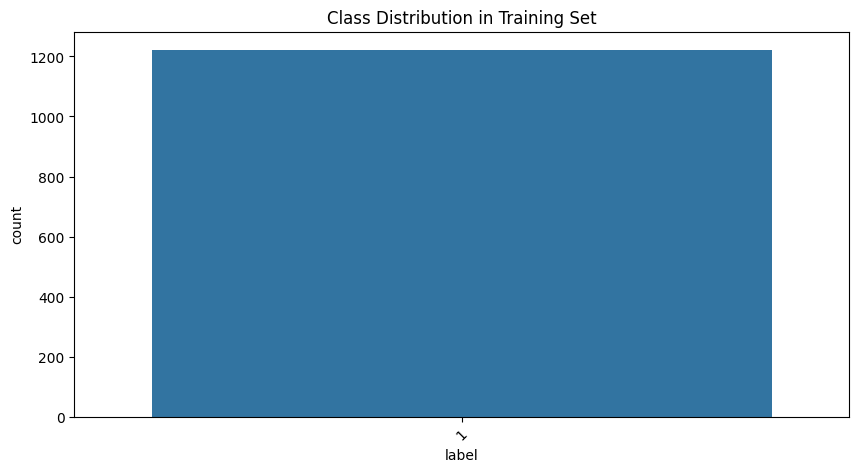

In [11]:
# Visualize the class distribution in the training set
plt.figure(figsize=(10, 5))
sns.countplot(data=train_labels_df, x='label')
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

**Adding new images**

## 4. Data Preprocessing
### 4.1. Defining Transformations

In [12]:
# Define transformations for training, validation, and testing
train_transform = transforms.Compose([
    transforms.Resize((245, 245)),  # EfficientNet-B3 input size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((245, 245)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((245, 245)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 4.2. Custom Dataset Classes

In [13]:
# Custom dataset class for training and validation
class SoilDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_id = os.path.basename(img_path)
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros(3, 300, 300), -1, img_id  # Dummy image for errors
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label, img_id

In [14]:
# Custom dataset for test images
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_id = os.path.basename(img_path)
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros(3, 300, 300), img_id
        
        if self.transform:
            image = self.transform(image)
        return image, img_id


### 4.3. Preparing Data

In [15]:
# Prepare the data by mapping images to labels and splitting into train/validation sets
# train_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir)]
# train_labels_map = train_labels_df.set_index('image_id')['class_name'].to_dict()
# train_labels = []
# valid_images = []
# for img in train_images:
#     img_id = os.path.basename(img)
#     if img_id in train_labels_map:
#         train_labels.append(label_map[train_labels_map[img_id]])
#         valid_images.append(img)
#     else:
#         print(f"Warning: {img_id} not in train_labels.csv")

In [16]:
# Split the data into training and validation sets
# train_img, val_img, train_lbl, val_lbl = train_test_split(
#     valid_images, train_labels, test_size=0.20, random_state=42, stratify=train_labels
# )

In [17]:
# Create datasets
# train_dataset = SoilDataset(train_img, train_lbl, train_transform)
# val_dataset = SoilDataset(val_img, val_lbl, val_transform)
# test_dataset = TestDataset(
#     [os.path.join(test_dir, img) for img in os.listdir(test_dir)],
#     test_transform
# )


In [18]:
# Existing soil image info
base_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025"
soil_train_dir = os.path.join(base_dir, "train")
train_labels_path = os.path.join(base_dir, "train_labels.csv")
train_labels_df = pd.read_csv(train_labels_path)

# Build full path for soil images
train_labels_df['filepath'] = train_labels_df['image_id'].apply(lambda x: os.path.join(soil_train_dir, x))
train_labels_df['label'] = train_labels_df['label'].astype(int)

# Label 1 is soil
soil_df = train_labels_df[['filepath', 'label']].copy()
soil_df.head()

natural_root = "/kaggle/input/d/briansurezsantiago/natural-images/NaturalDataset/Training"
excluded_dirs = {"flower", "fruit"}

# Get all image paths
all_natural_image_paths = glob(os.path.join(natural_root, "*", "*"))

# Filter out images from "flower" and "fruit"
natural_image_paths = [
    path for path in all_natural_image_paths
    if path.lower().endswith(('.jpg', '.jpeg', '.png')) and
       os.path.basename(os.path.dirname(path)) not in excluded_dirs
]

# Assign label 0 to all natural images
natural_df = pd.DataFrame({
    'filepath': natural_image_paths,
    'label': 0
})
# natural_df.head()

natural_df = natural_df.sample(2000)

combined_df = pd.concat([soil_df, natural_df], ignore_index=True)
combined_df = combined_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print(combined_df['label'].value_counts())

label
0    2000
1    1222
Name: count, dtype: int64


In [19]:
train_img, val_img, train_lbl, val_lbl = train_test_split(
    combined_df['filepath'], combined_df['label'], test_size=0.3, stratify=combined_df['label'], random_state=42
)

In [20]:
train_dataset = SoilDataset(train_img.tolist(), train_lbl.tolist(), train_transform)
val_dataset = SoilDataset(val_img.tolist(), val_lbl.tolist(), val_transform)
test_dataset = TestDataset(
    [os.path.join(test_dir, img) for img in os.listdir(test_dir)],
    test_transform
)

### 4.4. Creating Data Loaders

In [21]:
# Create data loaders for batching and shuffling
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2255
Validation dataset size: 967
Test dataset size: 967


### 4.5. Visualizing Sample Images

In [22]:
# Denormalize function for visualization
def denormalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.clone()
    for i in range(img.shape[0]):
        img[i] = img[i] * std[i] + mean[i]
    return img.clamp(0, 1)

In [23]:
# Visualize sample images per class
def show_samples_per_class(dataset, label_map, classes):
    fig, axes = plt.subplots(2, len(classes), figsize=(len(classes) * 3, 6))
    found = set()
    for img, label, img_id in dataset:
        if label not in found and label != -1:
            axes[0, label].imshow(img.permute(1, 2, 0).numpy())
            axes[0, label].set_title(f"Original\n{list(label_map.keys())[label]}")
            axes[0, label].axis('off')
            transformed = denormalize_image(img)
            axes[1, label].imshow(transformed.permute(1, 2, 0).numpy())
            axes[1, label].set_title(f"Transformed\n{list(label_map.keys())[label]}")
            axes[1, label].axis('off')
            found.add(label)
        if len(found) == len(classes):
            break
    plt.tight_layout()
    plt.show()

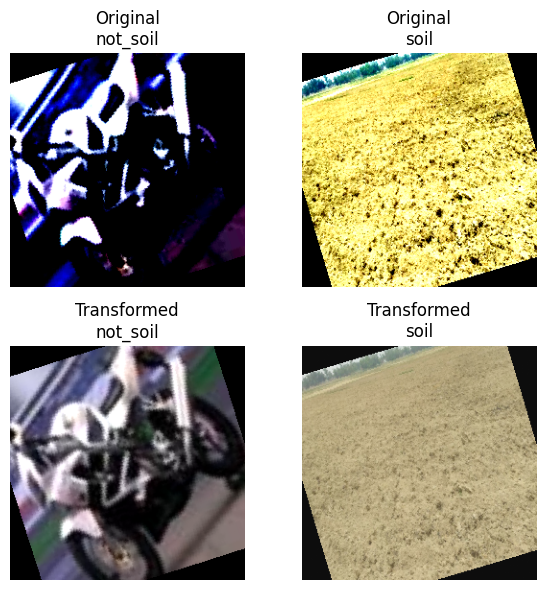

In [24]:
show_samples_per_class(train_dataset, label_map, classes)

## 5. Model Definition
### 5.1. Focal Loss

In [25]:
# Define Focal Loss to address class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

### 5.2. Initializing Models

In [26]:
class SoilFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        # Remove the last classification layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Output: (B, 512, 1, 1)
        self.fc = nn.Linear(512, 1)  # Binary output

    def forward(self, x):
        features = self.backbone(x)  # (B, 512, 1, 1)
        features = features.view(features.size(0), -1)  # Flatten to (B, 512)
        output = self.fc(features)
        return output


In [27]:
# Initialize models
models_dict = {
    "EfficientNet-B3": timm.create_model("efficientnet_b3", pretrained=True, num_classes=1),
    "ResNet-50": models.resnet50(pretrained=True)
}

# Adjust ResNet-50 classifier
models_dict["ResNet-50"].fc = nn.Linear(models_dict["ResNet-50"].fc.in_features, 1)

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


In [28]:
# models_dict = {}
# models_dict['Custom Model'] = SoilFeatureExtractor().to(device)

## 6. Training
### 6.1. Helper Functions

In [29]:
# Function to compute epoch time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
# Function to plot training and validation metrics
def plot_metrics(model_name, train_loss_list, train_acc_list, val_acc_list, val_f1_list):
    epochs = range(1, len(train_loss_list) + 1)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_acc_list, label='Train Accuracy')
    plt.plot(epochs, val_acc_list, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1_list, label='Validation F1 Score')
    plt.title(f'{model_name} - Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"/kaggle/working/{model_name.lower().replace('-', '_')}_metrics.png")
    plt.show()

### 6.2. Training Function

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path):
    best_f1 = 0
    epochs_no_improve = 0
    patience = 5
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []
    val_f1_list = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        t = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for images, labels, _ in t:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)  # Ensure shape [B, 1]

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            t.set_postfix(loss=loss.item(), accuracy=100 * correct_train / total_train)

        avg_train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(train_acc)

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = 100 * correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds)
        val_acc_list.append(val_acc)
        val_f1_list.append(val_f1)

        # Print epoch results
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f"\nEpoch {epoch+1}:")
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%, Validation F1 Score: {val_f1:.4f}")
        print(f"Time: {epoch_mins}m {epoch_secs}s")

        scheduler.step(val_f1)
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with F1: {best_f1:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # if epochs_no_improve >= patience:
        #     print("Early stopping triggered.")
        #     break

        torch.cuda.empty_cache()

    return best_f1, val_acc, train_loss_list, train_acc_list, val_acc_list, val_f1_list

In [32]:
# Updated fine-tune function
def fine_tune_model(model, model_name):
    for param in model.parameters():
        param.requires_grad = False
    
    if 'efficientnet' in model_name.lower():
        for name, param in model.named_parameters():
            if 'blocks.4' in name or 'blocks.5' in name or 'blocks.6' in name or 'head' in name or 'fc' in name:
                param.requires_grad = True
    elif 'resnet' in model_name.lower():
        for name, param in model.named_parameters():
            if 'layer3' in name or 'layer4' in name or 'fc' in name:
                param.requires_grad = True
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{model_name} - Total Parameters: {total_params:,}, Trainable Parameters: {trainable_params:,}")
    
    if trainable_params == 0:
        raise ValueError(f"No trainable parameters found for {model_name}.")

### 6.3. Training Models


Training EfficientNet-B3...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|██████████| 71/71 [00:28<00:00,  2.47it/s, accuracy=96.8, loss=0.0138]



Epoch 1:
Training Loss: 0.1332, Training Accuracy: 96.81%
Validation Accuracy: 99.90%, Validation F1 Score: 0.9986
Time: 0m 34s
Model saved with F1: 0.9986


Epoch 2/10: 100%|██████████| 71/71 [00:26<00:00,  2.69it/s, accuracy=99.6, loss=0.000326]



Epoch 2:
Training Loss: 0.0139, Training Accuracy: 99.56%
Validation Accuracy: 99.90%, Validation F1 Score: 0.9986
Time: 0m 30s


Epoch 3/10: 100%|██████████| 71/71 [00:27<00:00,  2.63it/s, accuracy=99.7, loss=0.00666]



Epoch 3:
Training Loss: 0.0185, Training Accuracy: 99.69%
Validation Accuracy: 99.69%, Validation F1 Score: 0.9959
Time: 0m 31s


Epoch 4/10: 100%|██████████| 71/71 [00:27<00:00,  2.58it/s, accuracy=99.9, loss=0.000321]



Epoch 4:
Training Loss: 0.0041, Training Accuracy: 99.87%
Validation Accuracy: 99.79%, Validation F1 Score: 0.9973
Time: 0m 31s


Epoch 5/10: 100%|██████████| 71/71 [00:27<00:00,  2.61it/s, accuracy=99.8, loss=4.14e-8]



Epoch 5:
Training Loss: 0.0036, Training Accuracy: 99.82%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s
Model saved with F1: 1.0000


Epoch 6/10: 100%|██████████| 71/71 [00:27<00:00,  2.60it/s, accuracy=99.9, loss=4.81e-11]



Epoch 6:
Training Loss: 0.0048, Training Accuracy: 99.87%
Validation Accuracy: 99.90%, Validation F1 Score: 0.9986
Time: 0m 31s


Epoch 7/10: 100%|██████████| 71/71 [00:27<00:00,  2.59it/s, accuracy=99.7, loss=2.45e-13]



Epoch 7:
Training Loss: 0.0075, Training Accuracy: 99.73%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


Epoch 8/10: 100%|██████████| 71/71 [00:27<00:00,  2.60it/s, accuracy=100, loss=1.04e-7]



Epoch 8:
Training Loss: 0.0008, Training Accuracy: 100.00%
Validation Accuracy: 99.90%, Validation F1 Score: 0.9986
Time: 0m 31s


Epoch 9/10: 100%|██████████| 71/71 [00:27<00:00,  2.59it/s, accuracy=100, loss=1.27e-7]



Epoch 9:
Training Loss: 0.0003, Training Accuracy: 100.00%
Validation Accuracy: 99.90%, Validation F1 Score: 0.9986
Time: 0m 31s


Epoch 10/10: 100%|██████████| 71/71 [00:27<00:00,  2.59it/s, accuracy=100, loss=4.36e-5]



Epoch 10:
Training Loss: 0.0000, Training Accuracy: 100.00%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


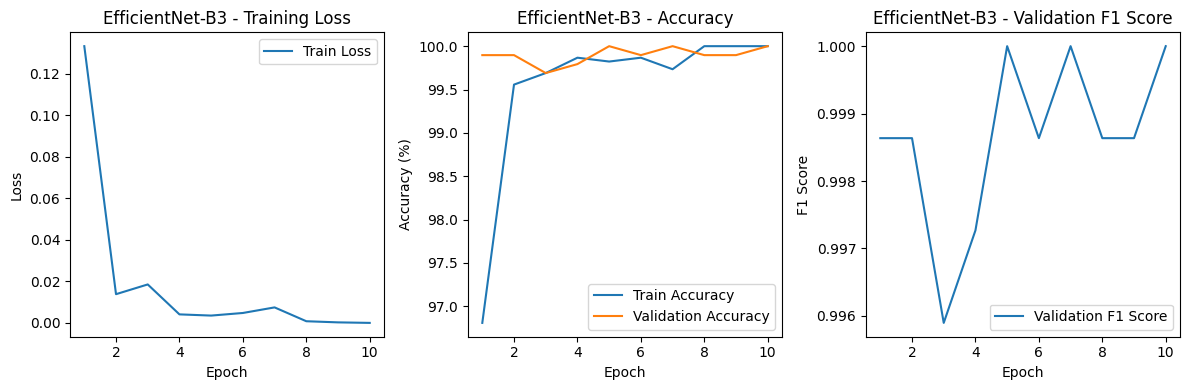

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training ResNet-50...


Epoch 1/10: 100%|██████████| 71/71 [00:27<00:00,  2.57it/s, accuracy=98.8, loss=0.125]



Epoch 1:
Training Loss: 0.0523, Training Accuracy: 98.76%
Validation Accuracy: 99.90%, Validation F1 Score: 0.9986
Time: 0m 31s
Model saved with F1: 0.9986


Epoch 2/10: 100%|██████████| 71/71 [00:27<00:00,  2.59it/s, accuracy=99.6, loss=0.000406]



Epoch 2:
Training Loss: 0.0116, Training Accuracy: 99.65%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s
Model saved with F1: 1.0000


Epoch 3/10: 100%|██████████| 71/71 [00:27<00:00,  2.57it/s, accuracy=100, loss=0.00281]



Epoch 3:
Training Loss: 0.0020, Training Accuracy: 100.00%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


Epoch 4/10: 100%|██████████| 71/71 [00:27<00:00,  2.58it/s, accuracy=99.6, loss=0.0093]



Epoch 4:
Training Loss: 0.0110, Training Accuracy: 99.60%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


Epoch 5/10: 100%|██████████| 71/71 [00:27<00:00,  2.59it/s, accuracy=99.6, loss=0.000141]



Epoch 5:
Training Loss: 0.0094, Training Accuracy: 99.56%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


Epoch 6/10: 100%|██████████| 71/71 [00:27<00:00,  2.59it/s, accuracy=99.6, loss=0.00198]



Epoch 6:
Training Loss: 0.0102, Training Accuracy: 99.65%
Validation Accuracy: 99.90%, Validation F1 Score: 0.9986
Time: 0m 31s


Epoch 7/10: 100%|██████████| 71/71 [00:27<00:00,  2.57it/s, accuracy=99.9, loss=0.000193]



Epoch 7:
Training Loss: 0.0045, Training Accuracy: 99.91%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


Epoch 8/10: 100%|██████████| 71/71 [00:27<00:00,  2.58it/s, accuracy=99.9, loss=0.00345]



Epoch 8:
Training Loss: 0.0027, Training Accuracy: 99.87%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


Epoch 9/10: 100%|██████████| 71/71 [00:27<00:00,  2.59it/s, accuracy=100, loss=0.000177]



Epoch 9:
Training Loss: 0.0006, Training Accuracy: 100.00%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


Epoch 10/10: 100%|██████████| 71/71 [00:27<00:00,  2.58it/s, accuracy=100, loss=0.0013]



Epoch 10:
Training Loss: 0.0004, Training Accuracy: 100.00%
Validation Accuracy: 100.00%, Validation F1 Score: 1.0000
Time: 0m 31s


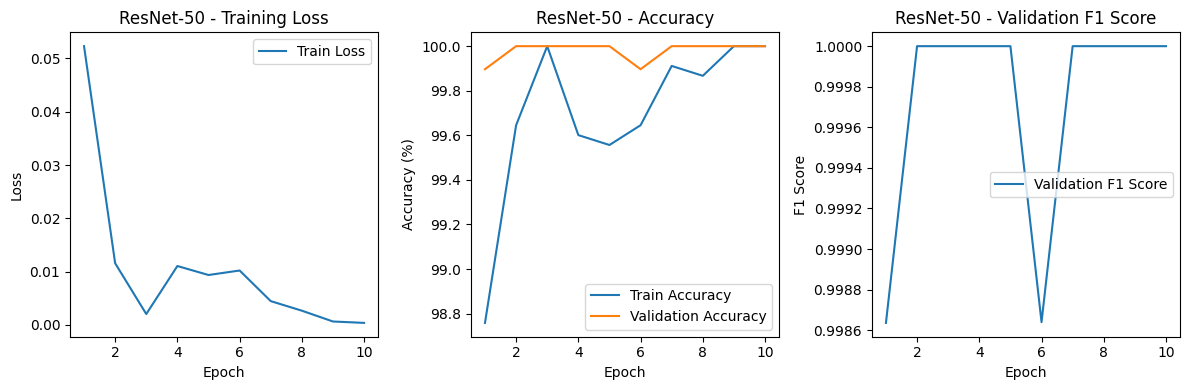

In [33]:
# Fine-tune and train each model for binary classification
results = {}
num_epochs = 10

for model_name, model in models_dict.items():
    print(f"\nTraining {model_name}...")

    # Custom fine-tuning logic per model (e.g., freeze/unfreeze layers)
    # fine_tune_model(model, model_name)

    model = model.to(device)

    # Binary classification loss
    criterion = nn.BCEWithLogitsLoss()

    # Optimizer for parameters that require gradients
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.0001
    )

    # Scheduler that monitors F1 score improvement
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    # File to save best model
    save_path = f"/kaggle/working/{model_name.lower().replace('-', '_')}_best_model.pth"

    # Train and validate
    best_f1, val_acc, train_loss_list, train_acc_list, val_acc_list, val_f1_list = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path
    )

    # Store metrics
    results[model_name] = {
        "best_f1": best_f1,
        "val_acc": val_acc,
        "train_loss_list": train_loss_list,
        "train_acc_list": train_acc_list,
        "val_acc_list": val_acc_list,
        "val_f1_list": val_f1_list
    }

    # Plot metrics for each model
    plot_metrics(model_name, train_loss_list, train_acc_list, val_acc_list, val_f1_list)

    # Update model dictionary with trained model
    models_dict[model_name] = model


In [34]:
 # models_dict[model_name] = model

## 7. Evaluation
### 7.1. Ensemble Prediction

In [35]:
# Function for ensemble prediction on validation set (binary classification)
def ensemble_predict(models, loader, device):
    for model in models:
        model.eval()

    all_preds = []
    all_labels = []
    all_ids = []

    with torch.no_grad():
        for images, labels, ids in loader:
            images = images.to(device)
            avg_outputs = torch.zeros((images.size(0), 1), device=device)

            # Average predictions from all models
            for model in models:
                outputs = model(images)
                avg_outputs += outputs / len(models)

            # Apply sigmoid and threshold at 0.5
            probs = torch.sigmoid(avg_outputs)
            preds = (probs > 0.5).long().squeeze(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_ids.extend(ids)

    # Calculate metrics
    val_acc = 100 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    val_f1 = f1_score(all_labels, all_preds, average='macro')

    return val_acc, val_f1, all_preds, all_labels, all_ids


In [36]:
# Function for ensemble prediction on test set (binary classification)
def ensemble_predict_test(models, loader, device):
    for model in models:
        model.eval()

    all_preds = []
    all_ids = []

    with torch.no_grad():
        for images, ids in loader:
            images = images.to(device)
            avg_outputs = torch.zeros((images.size(0), 1), device=device)

            for model in models:
                outputs = model(images)
                avg_outputs += outputs / len(models)

            # Apply sigmoid and threshold at 0.5
            probs = torch.sigmoid(avg_outputs)
            preds = (probs > 0.5).long().squeeze(1)

            all_preds.extend(preds.cpu().numpy())
            all_ids.extend(ids)

    return all_preds, all_ids


### 7.2. Evaluating Ensemble

In [37]:
# Evaluate ensemble
ensemble_models = list(models_dict.values())
ensemble_acc, ensemble_f1, val_preds, val_labels, val_ids = ensemble_predict(ensemble_models, val_loader, device)
results["Ensemble"] = {"best_f1": ensemble_f1, "val_acc": ensemble_acc}

## 8. Visualization
### 8.1. Model Comparison

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


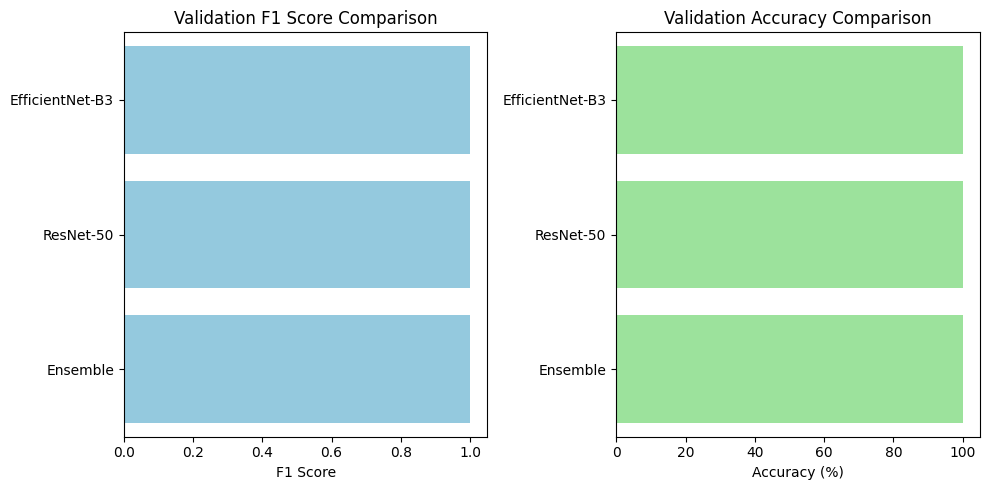


Model Performance Summary:
EfficientNet-B3: F1 Score = 1.0000, Accuracy = 100.00%
ResNet-50: F1 Score = 1.0000, Accuracy = 100.00%
Ensemble: F1 Score = 1.0000, Accuracy = 100.00%


In [38]:
# Visualize comparison of Models
plt.figure(figsize=(10, 5))
model_names = list(results.keys())
f1_scores = [results[name]["best_f1"] for name in model_names]
acc_scores = [results[name]["val_acc"] for name in model_names]

plt.subplot(1, 2, 1)
sns.barplot(x=f1_scores, y=model_names, color='skyblue')
plt.title("Validation F1 Score Comparison")
plt.xlabel("F1 Score")

plt.subplot(1, 2, 2)
sns.barplot(x=acc_scores, y=model_names, color='lightgreen')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Accuracy (%)")
plt.tight_layout()
plt.savefig("/kaggle/working/model_comparison.png")
plt.show()

# Print results
print("\nModel Performance Summary:")
for name in results:
    print(f"{name}: F1 Score = {results[name]['best_f1']:.4f}, Accuracy = {results[name]['val_acc']:.2f}%")

### 8.2. Confusion Matrix

In [39]:
classes

['not_soil', 'soil']

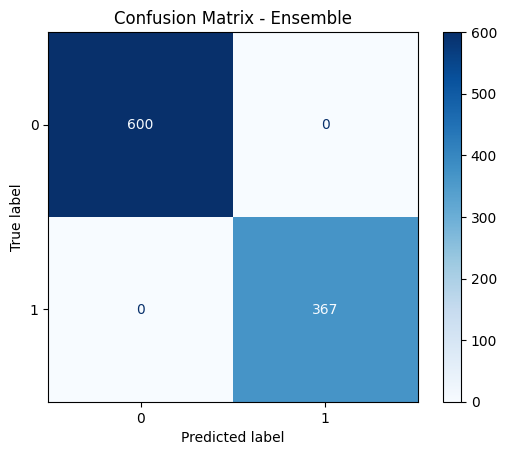

In [40]:
## Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Ensemble")
plt.savefig("/kaggle/working/confusion_matrix.png")
plt.show()

### 8.3. Per-class F1 Scores

In [41]:
## Per-class F1 Scores
per_class_f1 = f1_score(val_labels, val_preds, average=None)
print("\nPer-class F1 Scores:")
for cls, f1 in zip(classes, per_class_f1):
    print(f"{cls}: {f1:.4f}")


Per-class F1 Scores:
not_soil: 1.0000
soil: 1.0000


### 8.4. Misclassification Analysis

In [42]:
## Misclassification Analysis and Visualization
misclassified_idx = [i for i, (p, l) in enumerate(zip(val_preds, val_labels)) if p != l]
num_to_show = min(10, len(misclassified_idx))
if num_to_show > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, idx in enumerate(misclassified_idx[:num_to_show]):
        image, true_label, img_id = val_dataset[idx]
        image = denormalize_image(image)
        image = image.permute(1, 2, 0).numpy()
        pred_label = val_preds[idx]
        axes[i].imshow(image)
        axes[i].set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.savefig("/kaggle/working/misclassified_samples.png")
    plt.show()
else:
    print("No misclassified samples to visualize.")

No misclassified samples to visualize.


### 8.5. Class-wise Misclassification Rates

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


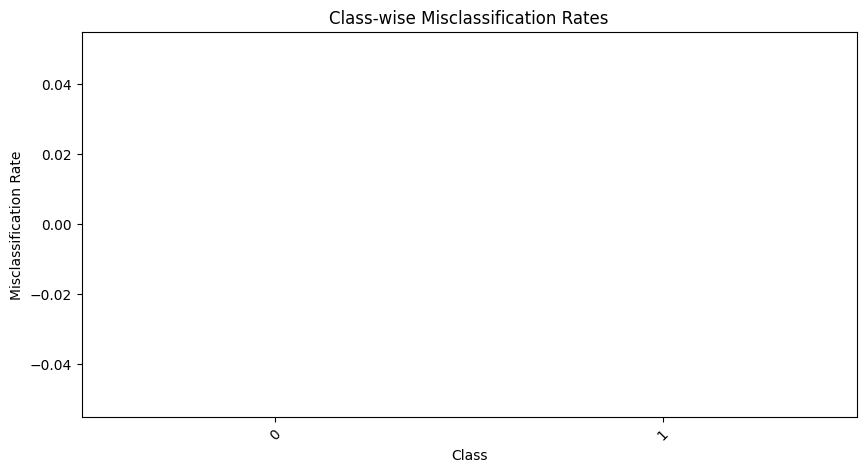

In [43]:
## Class-wise Misclassification Rates
class_counts = Counter(val_labels)
misclassified_counts = Counter()
for p, l in zip(val_preds, val_labels):
    if p != l:
        misclassified_counts[l] += 1
misclassification_rates = {cls: misclassified_counts.get(cls, 0) / class_counts[cls] for cls in class_counts}
plt.figure(figsize=(10, 5))
sns.barplot(x=list(misclassification_rates.keys()), y=list(misclassification_rates.values()))
plt.title("Class-wise Misclassification Rates")
plt.xlabel("Class")
plt.ylabel("Misclassification Rate")
plt.xticks(rotation=45)
plt.savefig("/kaggle/working/misclassification_rates.png")
plt.show()

## 9. Submission

In [44]:
# Predicted Class Counts on Test Set
test_preds, test_ids = ensemble_predict_test(ensemble_models, test_loader, device)
predicted_counts = Counter(test_preds)
print("\nPredicted Class Counts on Test Set:")
for cls_idx, count in predicted_counts.items():
    print(f"{classes[cls_idx]}: {count}")



Predicted Class Counts on Test Set:
not_soil: 604
soil: 363


In [45]:
## Submission File
submission_df = pd.DataFrame({
    "image_id": test_ids,
    "label": [p for p in test_preds]
})


In [46]:
submission_df.loc[submission_df['image_id'] == '01d8f285ca985154a0fa5e824863ab27.jpg']

,image_id,label
16,01d8f285ca985154a0fa5e824863ab27.jpg,0


In [47]:
submission_df.head()

,image_id,label
0,465084323936570da664f0ca8dc90326.jpg,0
1,1aa0b12029d35e778dba5bff1255c638.jpg,1
2,6df2c3dcd4fb59298c7a73467ea72eeb.jpg,0
3,107f25ebd87f581ea57c630a2dcdf50c.jpg,1
4,dc35d58782615e4f9582c6b32c8b956e.jpg,0


In [48]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)
print("\nSubmission file saved to /kaggle/working/submission.csv")


Submission file saved to /kaggle/working/submission.csv
